# 194.045 Data Stewardship UE (2025S)

This exemplary Jupyter notebooks should help you get going with Part 2. Further Python help is available on [PyPI](https://pypi.org/project/dbrepo/) or the [documentation](https://www.ifs.tuwien.ac.at/infrastructures/dbrepo/1.7/python/guide/rest-client.html) website.

## 1 Deposit Dataset

Navigate to the DBRepo Test Instance https://test.dbrepo.tuwien.ac.at and login with your TU account.

Create a database with the UI by clicking the "+ Database" button and typing a name. Click "Create" once you're done.

<img src=".help/1_create_database.png" style="max-width: 1024" alt="" />

Navigate to "Create Table" and give your table a name and description. It is **important** to set both Transparency and Insights to "Visible" to make your dataset publicly visible. Set the structure information (most CSV datasets have a top row with column names) and separator (usually comma `,`). Select your dataset to upload and click "Upload & Analyse".

<img src=".help/2_create_table.png" style="max-width: 1024" alt="" />

Once the upload is finished, the DBRepo suggests column data types and constraints (e.g. column is allowed to have `NULL` value). Select at least 1 column that is a primary key (must be non-`NULL`, unique in value). These are usually called something-`id`ish. Then click "Continue". Wait for the table creation and click "Import Data".

On the next page, finally import the data by clicking the button "Import", the structure  and dataset is filled from the previous step. In case of an import error, set the separator according to your CSV.

<img src=".help/4_import_data.png" style="max-width: 1024" alt="" />

## 2 Create Subset

Now that you have uploaded your dataset, it is time to create a meaningful subset that can be used for analysis. Select the columns and use at least 1 filter condition and 1 sorting condition. Click "Create" when you want to create the subset.

<img src=".help/5_create_subset.png" style="max-width: 1024" alt="" />

Finally, mark your subset to be visible in the UI by clicking the "Star" button. Click "Get PID" and create a PID similar to InvenioRDM.

## 3 Get Data

Install the dependencies from the requirements.txt file.

In [1]:
!pip install -r requirements.txt

   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 2.0/2.0 MB 18.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Get the data from your persisted subset by the PID:

In [5]:
from dbrepo.RestClient import RestClient
client = RestClient(endpoint="https://test.dbrepo.tuwien.ac.at", username="12433699", password="Ajdina14+")
#df = client.get_identifier_data(identifier_id="7a647061-faf8-4c7d-9e1b-58432dd0aa22")
df_train = client.get_identifier_data(
  identifier_id="d020b222-851a-45ad-a5ad-6b88fd77baf8"
)
df_valid = client.get_identifier_data(identifier_id="6517a989-d4b2-4eb1-9909-278dde12521b")
df_test  = client.get_identifier_data(identifier_id="87e780fa-55bc-4156-8e7b-3c56633db625")

In [6]:
print("Train:", df_train.shape)
print("Valid:", df_valid.shape)
print("Test: ", df_test.shape)


Train: (2152, 12)
Valid: (461, 12)
Test:  (462, 12)


In [9]:
#check for overfitting
# none of the actionnr in train should appear in valid/test
common_tv = set(df_train['actionnr']).intersection(df_valid['actionnr'])
common_tt = set(df_train['actionnr']).intersection(df_test['actionnr'])
common_vt = set(df_valid['actionnr']).intersection(df_test['actionnr'])
print(common_tv, common_tt, common_vt)  # each should be empty set()


set() set() set()


## Help!

If you cannot login to the DBRepo Test Instance or have weird error messages you cannot figure out on your own, contact [martin.weise@tuwien.ac.at](mailto:martin.weise@tuwien.ac.at).

## Notebook

In [21]:
import pandas as pd

# Load directly from the current directory
df = pd.read_csv('credit_card.csv')
print(df.shape)
df.head()


(3075, 12)


,actionnr,merchant_id,average_amount_transaction_day,transaction_amount,is_declined,total_number_of_declines_day,isforeigntransaction,ishighriskcountry,daily_chargeback_avg_amt,sixmonth_avg_chbk_amt,sixmonth_chbk_freq,isfradulent
0,1,3160040998,100.0,3000.0,N,5,Y,Y,0,0.0,0,Y
1,2,3160040998,100.0,4300.0,N,5,Y,Y,0,0.0,0,Y
2,3,3160041896,185.5,4823.0,Y,5,N,N,0,0.0,0,Y
3,4,3160141996,185.5,5008.5,Y,8,N,N,0,0.0,0,Y
4,5,3160241992,500.0,26000.0,N,0,Y,Y,800,677.2,6,Y


In [24]:
# Identify the columns you don’t want as features
id_col    = 'actionnr'
label_col = 'isfradulent'


In [23]:
# Show all column names so we pick the correct label
print(df.columns.tolist())


['actionnr', 'merchant_id', 'average_amount_transaction_day', 'transaction_amount', 'is_declined', 'total_number_of_declines_day', 'isforeigntransaction', 'ishighriskcountry', 'daily_chargeback_avg_amt', 'sixmonth_avg_chbk_amt', 'sixmonth_chbk_freq', 'isfradulent']


In [25]:
# X: all columns except the ID and the label
X = df.drop([id_col, label_col], axis=1)

# y: the label
y = df[label_col]


#Train Test Split

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)


In [28]:
# --- Preprocessing cell ---

# Map Y/N columns to 0/1
bool_cols = [
    'is_declined',
    'isforeigntransaction',
    'ishighriskcountry',
    'isfradulent'        # also map the label here
]
for col in bool_cols:
    df[col] = df[col].map({'Y': 1, 'N': 0})

# Drop identifier columns you won't train on
df = df.drop(['actionnr', 'merchant_id'], axis=1)

# Verify everything is now numeric
print(df.dtypes)


average_amount_transaction_day    float64
transaction_amount                float64
is_declined                         int64
total_number_of_declines_day        int64
isforeigntransaction                int64
ishighriskcountry                   int64
daily_chargeback_avg_amt            int64
sixmonth_avg_chbk_amt             float64
sixmonth_chbk_freq                  int64
isfradulent                         int64
dtype: object


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       789
           1       0.98      0.95      0.97       134

    accuracy                           0.99       923
   macro avg       0.99      0.97      0.98       923
weighted avg       0.99      0.99      0.99       923



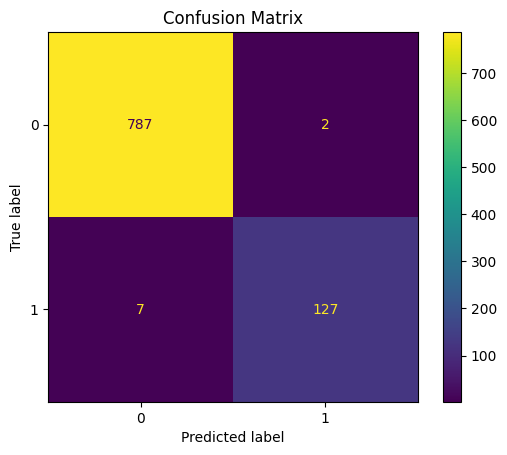

In [29]:
# Step 4.x: Split, train, and evaluate on the cleaned data

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1) Build features X and label y
X = df.drop('isfradulent', axis=1)
y = df['isfradulent']

# 2) Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# 3) Train the RandomForest
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# 4) Print performance
print("=== Classification Report ===")
print(classification_report(y_test, clf.predict(X_test)))

# 5) Show confusion matrix
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()


## Serialize model & save outputs


✔ Model saved to rf_model_v1.joblib
✔ Confusion matrix saved
✔ ROC curve saved
✔ Predictions saved to predictions.csv


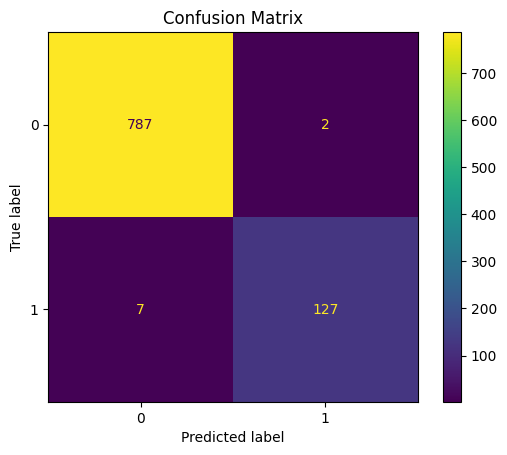

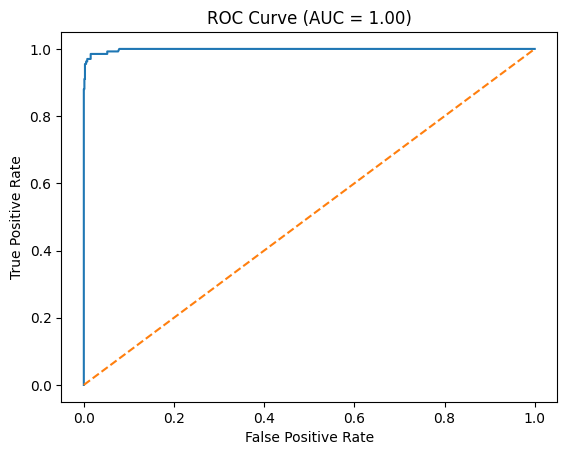

In [30]:
import joblib, matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
import pandas as pd

# 1) Serialize your trained classifier (`clf`)
model_path = "rf_model_v1.joblib"
joblib.dump(clf, model_path)
print("✔ Model saved to", model_path)

# 2) Save confusion matrix plot
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax)
plt.title("Confusion Matrix")
fig.savefig("confusion_matrix.png")
print("✔ Confusion matrix saved")

# 3) Save ROC curve plot
y_score = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.title(f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig("roc_curve.png")
print("✔ ROC curve saved")

# 4) Save predictions to CSV
preds = pd.DataFrame({
    "actionnr":   X_test.index,
    "true":       y_test,
    "predicted":  clf.predict(X_test),
    "score":      y_score
})
preds.to_csv("predictions.csv", index=False)
print("✔ Predictions saved to predictions.csv")


In [31]:
import os

os.environ["TUWRD_USER"] = "e12433699"
os.environ["TUWRD_PW"]   = "Ajdina14"


In [32]:
import requests, json, os

def upload_to_tuwrd(title, description, creators, license_url, file_paths):
    # 1) Create record
    md = {
      "title":       title,
      "description": description,
      "creators":    creators,
      "license":     license_url,
      "keywords":    ["creditcard","fraud","randomforest"]
    }
    r = requests.post(
      "https://test.researchdata.tuwien.ac.at/api/v1/records",
      auth=(os.environ["TUWRD_USER"], os.environ["TUWRD_PW"]),
      headers={"Content-Type":"application/json"},
      data=json.dumps(md)
    )
    r.raise_for_status()
    rec = r.json()
    pid = rec["identifier"]  # may also appear under rec["id"]
    print("➤ Created TUWRD record:", pid)

    # 2) Upload files
    for path in file_paths:
        with open(path, "rb") as fp:
            files = {"file": (os.path.basename(path), fp)}
            up = requests.post(
              f"https://test.researchdata.tuwien.ac.at/api/v1/records/{rec['id']}/files",
              auth=(os.environ["TUWRD_USER"], os.environ["TUWRD_PW"]),
              files=files
            )
            up.raise_for_status()
            print("  • Uploaded", os.path.basename(path))
    return pid
